# CISC 873 Data Mining - A1 - Wish.com Product Rating Prediction
## Gavin McClelland - 15gm8 - 10211444
### Due: Monday 4 October 2021, 23:59 EST

⏰⚠ This notebook has been adapted from the provided template "a0_walkthrough_2021.ipynb"⚠⏰

# Tasks

## Task 1 - Meme Competition!🔥


![picture](https://drive.google.com/uc?id=1DFmoesqab4-Oe2I32ji28sjlUrp46ung)


## Task 2 - Problem Formulation


The objective of this task is to predict the rating of a given product on Wish.com given a set of features. Here, the input will be the variables containing details about the product that are believed to contribute to the rating score. The output will be the predicted product rating (categorical 1-5). This requires different preprocessing measures including (but not limited to) categorical encoding, imputation, feature scaling, and feature normalization. Furthermore, training and validation splits will be created before benchmarking different models. Then, these models will be tweaked to optimize performance on the test set. Anticipated challenges are implementing effective preprocessing measures, and selecting the appropriate features to optimize model performance. The impact of this work would allow consumers to purchase from Wish.com with confidence, and create a better understanding of product features that contribute to the quality of a given product. As such, an "ideal" solution to this problem would be a model that generalizes well to a wide range of products that have both poor and high quality ratings. This is why micro f1-score is appropriate for this problem, as we don't just want the model to be precise in detecting true positives, we also want it to be sensitive to false negatives as well (i.e. mis-labelling a product as a rating of 1 when it actually has a rating of 5).

## Task 3. Understand the Template
See comments on each line, and throughout when comments address more than one line. Please note that comments were not added to lines that already had descriptive comments, unless more detail could be provided than in the template.

In [3]:
# Importing dependencies
import pandas as pd # pandas is used for tabular data manipulation and preprocessing
import numpy as np # used for fast mathematical operations on arrays and linear algebra operations
from sklearn.linear_model import LogisticRegression # model used by the template
from sklearn.metrics import f1_score # evaluation metric for competition, mean f1-score
from pprint import pprint # pretty print is used to display python objects in the interpreter in a nice format (i.e. dicts)

In [4]:
data = pd.read_csv('/content/train_new.csv').sample(frac=1) #shuffle, reading csv into a dataframe
data = data.loc[data['rating'].isin([1, 2, 3, 4, 5])] # takes slice of data where records have numeric rating 1, 2, 3, 4, or 5
data = data.fillna(0) # fills all NaN values in the dataframe
data = data.drop(['merchant_id', 'merchant_profile_picture', 'id', 'tags'], axis=1) # dropping metadata columns that don't hold any descriptive value

In [5]:
msk = np.random.rand(len(data)) < 0.7 # creates a maskto select 70% of the dataset by randomly sampling indices from a uniform distribution over [0,1) 
tr = data[msk] # select 70% of the dataset for the training split
val = data[~msk] # select the remaining 30% of the dataset for the validation/development split using the inverse mask

In [6]:
tr # training split

,price,retail_price,currency_buyer,units_sold,uses_ad_boosts,rating,rating_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,product_color,product_variation_size_id,product_variation_inventory,shipping_option_name,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,urgency_text,origin_country,merchant_title,merchant_name,merchant_info_subtitle,merchant_rating_count,merchant_rating,merchant_has_profile_picture,theme,crawl_month
831,11.0,10,EUR,100,0,4.0,89,0,0,0,0,rose,XS,17,Livraison standard,3,0,32,50,0.0,0,CN,zhiceyang,zhice,74 % avis positifs (88 notes),88,3.556818,0,summer,2020-08
90,8.0,7,EUR,5000,1,4.0,1269,0,0,0,0,coffee,XXS,10,Livraison standard,2,0,38,50,0.0,0,CN,SZ Globe Fashion World,szglobefashionworld,"(39,395 notes)",39395,4.054423,0,summer,2020-08
642,8.0,7,EUR,5000,1,4.0,743,0,0,0,0,green,L,31,Livraison standard,3,0,48,50,0.0,0,CN,realmhome,ssshowsmart,"84 % avis positifs (4,178 notes)",4178,3.937530,0,summer,2020-08
1082,6.0,17,EUR,5000,0,4.0,1650,1,0,1,0,white,S,50,Livraison standard,2,0,44,50,0.0,0,CN,Sunshine754,sunshine754,"88 % avis positifs (13,308 notes)",13308,4.155996,0,summer,2020-08
510,13.0,33,EUR,1000,1,4.0,122,0,0,0,0,grey,S,50,Livraison standard,3,0,44,50,0.0,0,US,wf06,wf06,86 % avis positifs (114 notes),114,4.149123,0,summer,2020-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,9.0,50,EUR,20000,0,5.0,2440,0,0,0,0,black,M,50,Livraison standard,3,0,41,50,0.0,0,CN,hanzhy,hanzhy,"85 % avis positifs (15,106 notes)",15106,4.007149,0,summer,2020-08
1064,9.0,34,EUR,100,1,3.0,28,0,0,0,0,navyblue,XS,50,Livraison standard,3,0,40,50,0.0,0,CN,RoseWiner,rosewiner,"73 % avis positifs (1,472 notes)",1472,3.534647,0,summer,2020-08
133,2.0,8,EUR,50,0,4.0,8,0,0,0,0,gray,XXS,1,Livraison standard,1,0,40,50,1.0,Quantité limitée !,CN,schmuckdesignonline,schmuckdesignonline,"83 % avis positifs (7,248 notes)",7248,3.943019,0,summer,2020-08
26,7.0,6,EUR,100,0,4.0,71,0,0,0,0,navyblue,s,50,Livraison standard,2,0,36,50,0.0,0,CN,liminny,liminny,"81 % avis positifs (12,134 notes)",12134,3.866903,0,summer,2020-08


In [7]:
dict_cat = {} # dictionary used to store categorical column encodings


# columns that are of categorical value
cat_cols = tr.columns[tr.dtypes==object].to_list()



def cat_digit(col):  
    # build the mapping
    encoded = col.astype('category').cat.codes
    # store the mapping
    dict_cat[col.name] = dict(zip(np.asarray(col), np.asarray(encoded)))
    return encoded

# for each categorical feature, apply cat_digit where we build the mapping and transform the data
# this is for the training set (where we build the mapping)
tr[cat_cols] = tr[cat_cols].apply(lambda col: cat_digit(col))
tr

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,price,retail_price,currency_buyer,units_sold,uses_ad_boosts,rating,rating_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,product_color,product_variation_size_id,product_variation_inventory,shipping_option_name,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,urgency_text,origin_country,merchant_title,merchant_name,merchant_info_subtitle,merchant_rating_count,merchant_rating,merchant_has_profile_picture,theme,crawl_month
831,11.0,10,0,100,0,4.0,89,0,0,0,0,57,58,17,4,3,0,32,50,0.0,0,1,565,543,153,88,3.556818,0,0,0
90,8.0,7,0,5000,1,4.0,1269,0,0,0,0,21,61,10,4,2,0,38,50,0.0,0,1,173,423,79,39395,4.054423,0,0,0
642,8.0,7,0,5000,1,4.0,743,0,0,0,0,29,29,31,4,3,0,48,50,0.0,0,1,438,400,300,4178,3.937530,0,0,0
1082,6.0,17,0,5000,0,4.0,1650,1,0,1,0,65,34,50,4,2,0,44,50,0.0,0,1,199,410,456,13308,4.155996,0,0,0
510,13.0,33,0,1000,1,4.0,122,0,0,0,0,30,34,50,4,3,0,44,50,0.0,0,4,509,468,362,114,4.149123,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,9.0,50,0,20000,0,5.0,2440,0,0,0,0,10,30,50,4,3,0,41,50,0.0,0,1,333,141,325,15106,4.007149,0,0,0
1064,9.0,34,0,100,1,3.0,28,0,0,0,0,47,58,50,4,3,0,40,50,0.0,0,1,160,344,147,1472,3.534647,0,0,0
133,2.0,8,0,50,0,4.0,8,0,0,0,0,28,61,1,4,1,0,40,50,1.0,1,1,447,355,268,7248,3.943019,0,0,0
26,7.0,6,0,100,0,4.0,71,0,0,0,0,47,65,50,4,2,0,36,50,0.0,0,1,380,234,194,12134,3.866903,0,0,0


In [8]:
print('categorical features')
pprint(list(dict_cat.keys())) # lists keys of dictionary containing categorical encodings, use pprint(dict_cat) to see full dict

categorical features
['currency_buyer',
 'product_color',
 'product_variation_size_id',
 'shipping_option_name',
 'urgency_text',
 'origin_country',
 'merchant_title',
 'merchant_name',
 'merchant_info_subtitle',
 'theme',
 'crawl_month']


In [9]:
print('Lets see what the mapping for column origin_country :')
pprint(dict_cat['origin_country']) # categorical encoding for the origin_country field
print('It is a string to integer mapping')

Lets see what the mapping for column origin_country :
{0: 0, 'CN': 1, 'GB': 2, 'SG': 3, 'US': 4, 'VE': 5}
It is a string to integer mapping


In [10]:
# then we will use the mappings built from the training set, to transform the validation set
val[cat_cols] = val[cat_cols].apply(lambda col: col.map(dict_cat[col.name]))
# for string values that not seen in training set, we replace it with -1
val = val.fillna(-1) # replace all unseen/NaN values with -1
val

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,price,retail_price,currency_buyer,units_sold,uses_ad_boosts,rating,rating_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,product_color,product_variation_size_id,product_variation_inventory,shipping_option_name,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,urgency_text,origin_country,merchant_title,merchant_name,merchant_info_subtitle,merchant_rating_count,merchant_rating,merchant_has_profile_picture,theme,crawl_month
301,5.85,43,0,100,1,4.0,45,0,0,0,0,44.0,-1.0,50,4.0,1,0,45,50,0.0,0.0,1,-1.0,-1.0,-1.0,1972,4.340771,1,0,0
16,6.00,6,0,5000,0,4.0,506,0,0,0,0,72.0,58.0,7,4.0,2,0,24,50,0.0,0.0,1,-1.0,-1.0,-1.0,2127,3.817583,0,0,0
756,12.00,85,0,1000,1,4.0,153,0,0,0,0,-1.0,34.0,50,4.0,3,0,40,50,1.0,1.0,1,-1.0,-1.0,-1.0,15551,4.233683,0,0,0
924,13.00,34,0,100,0,4.0,54,0,0,0,0,72.0,58.0,50,4.0,3,0,41,50,0.0,0.0,1,269.0,41.0,341.0,4080,3.987990,0,0,0
704,4.00,4,0,100,1,5.0,2,0,0,0,0,52.0,58.0,1,4.0,1,0,20,50,0.0,0.0,1,-1.0,-1.0,-1.0,2707,4.189139,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,2.00,10,0,100,0,3.0,10,0,0,0,0,65.0,61.0,1,4.0,1,0,41,50,1.0,1.0,1,-1.0,-1.0,-1.0,8225,3.990638,0,0,0
554,3.68,4,0,100,0,4.0,42,0,0,0,0,45.0,58.0,1,4.0,1,0,38,50,0.0,0.0,0,132.0,282.0,180.0,105015,3.789601,0,0,0
942,4.67,4,0,10000,1,4.0,2151,0,0,0,0,14.0,-1.0,50,4.0,1,0,138,50,1.0,-1.0,1,154.0,329.0,136.0,96838,4.264659,0,0,0
743,15.00,13,0,100,0,4.0,56,0,0,0,0,36.0,29.0,50,4.0,4,0,41,50,0.0,0.0,1,-1.0,-1.0,-1.0,2166,4.030471,0,0,0


In [11]:
tr_y = tr['rating'] # slice containing label (target attribute)
tr_x = tr.drop('rating', axis=1) # slice containing all features, keeping everything but the target
clf = LogisticRegression().fit(tr_x, tr_y) # create Logistic Regression classifier

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [12]:
val_y = val['rating'] # slice containing label (target attribute)
val_x = val.drop('rating', axis=1) # slice containing all features, keeping everything but the target
pred_val = clf.predict(val_x) # predict target attribute given features

In [13]:
val_score = f1_score(val_y, pred_val, average='micro') # compute micro f1-score on the validation split using predictions from previous cell
print(val_score) # this could be a little bit better💩

0.6805111821086262


In [14]:
# once you are happy with your local model, let's prepare a submission
# we need to apply the same preprocessing steps on the testing set as you did before you train the model

test_data = pd.read_csv('/content/test_new.csv').sample(frac=1) # read test data
_id = test_data['id'] # keep track of ids for assigning predictions
test_data = test_data.fillna(0) # fill all NaNs with 0
test_data = test_data.drop(['merchant_id', 'merchant_profile_picture', 'id', 'tags'], axis=1) # dropping unhelpful columns, as before
test_data[cat_cols] = test_data[cat_cols].apply(lambda col: col.map(dict_cat[col.name])) # creating numerical encoding, as done in train & validation splits

# again, not-seen string value filled with -1
test_data = test_data.fillna(-1)

In [15]:
pred_test = clf.predict(test_data) # create predictions using LogReg classifier!
pred_df = pd.DataFrame(data={'id': np.asarray(_id), 'rating': pred_test}) # create dataframe in desired submission format
pred_df.to_csv('pred_walkthrough.csv', index=False) # create csv for submission

*Additional Questions Below*

**What is the experimental protocol used and how was it carried out?**

The experimental protocol used is that of a traditional multi-class classification/categorization problem. This is carried out using a training split to train the model, followed by using a holdout/validation/development set, which evaluates the trained model performance prior to testing. Categorical columns are categorically encoded to enrich the feature space.

**What preprocessing steps are used in the template? In this template, the following preprocessing steps are applied:**
1. Read the train/test data into a dataframe, using .sample(frac=1) reads all records in a shuffled order by sampling without replacement. 
2. Take the slice of the dataframe that has a product rating of 1,2,3,4, or 5. (noting that every single training sample has a rating in this range)
3. Fill all NaN values in the dataframe with 0
4. Drop the columns 'merchant_id', 'merchant_profile_picture', 'id', 'tags', which hold metadata and no descriptive value
5. Use 70% of training data for training, and the remaining 30% for validation/development. This is done to achieve sufficient performance on the validation set prior to testing. In this example a logical mask is created to select 70% of the records, where the negation of this mask is used to select the remaining 30% for the validation set.
6. All categorical columns (initially 'object' data type) are numerically encoded using enum mappings and replaced in the original dataframe. An example mapping is shown in the template for the 'origin_country' column.
7. Step 6 is also applied to the validation split, using the 'dict_cat' populated when creating the mappings for the training split (since the columns remain the same, we can just lookup the mapping this time instead of generating new ones)
8. All string values in the validation split that are not seen in the training split are replaced with -1
9. For training, take a slice of the features in tr_x and the label in tr_y, then fit the LogisticRegression classifier.
10. These same preprocessing steps (points 1-4, and 6) are applied to the test set before generating predictions.

**What is the model being used?** 

Logistic Regression is used. Since this is a multi-class problem, each product rating in the set of {1,2,3,4,5} is assigned a probability in [0,1] with the highest being assigned as the predicted label (these probabilities sum to 1). 

## Task 4 - Model Tuning and Documentation
With the baseline logistic regression model created in the template (task 3), let's see how much better we can do!😎

Note: all scores discussed in trial thoughts are the micro f1-scores on the public Kaggle leaderboard.

### Trial 1 - Basic Hyperparameter Tuning

Thoughts and observations for trial 0 (baseline): This is a generic LogisticRegression model with no hyperparameters. Opening up the 'pred_walkthrough.csv' generated in the template, all of the predicted ratings are '4', except for four ratings of '3' and one rating of '5', so the model is not fitting to the data at all as it appears to pick the most common product rating (micro f1-score: 0.72384)

Plan for trial 1: verifying assumption that the most common rating appears to be selected for almost all records, and play around with hyperparameters (penalties/regularizers, class weights, solvers) to explore if there are any 'quick wins', or ways to improve the performance of the logistic regression. Once any noticeable improvement in validation score is achieved, a submission will be made to the public leaderboard to see how it does! 😀 

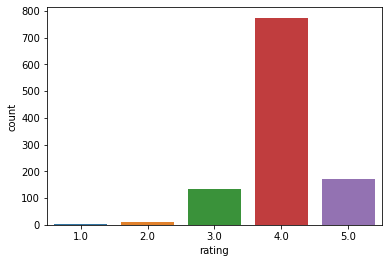

In [16]:
import seaborn as sns # used for heatmaps and simple visuals
import matplotlib.pyplot as plt # I use pyplot for adjusting the size of my plots

sns.countplot(x="rating", data=data) # one liner to visualize class distribution

# So, we can see that the majority of the products in the dataset have a
# rating of 4, as I guessed, the dataset is imbalanced

In [17]:
# creating a reusable function to train a classifier, then compute 
# the validation score (adapted from code in template)

def train_and_validate(model, x_train, y_train, x_val, y_val):
  model.fit(x_train, y_train) # train the model
  pred_val = model.predict(x_val) # generate predictions on validation set
  val_score = f1_score(y_val, pred_val, average='micro') # compute f1-score against validation set
  return val_score

def test(model, trial_no, test):
  pred_test = model.predict(test) # create predictions using a model on the test split
  pred_df = pd.DataFrame(data={'id': np.asarray(_id), 'rating': pred_test}) # create dataframe in desired submission format
  pred_df.to_csv(f'{trial_no}_predictions.csv', index=False) # create csv for submission

# I know a train_test_split method exists in sklearn but I made this quickly using some of the template code
def split(data):
  msk = np.random.rand(len(data)) < 0.7  # apply mask
  tr = data[msk]  # extract training split (70%)
  val = data[~msk] # extract validation split (30%)
  
  # split up labels and features for return values
  tr_x = tr.drop(columns=['rating']) 
  val_x = val.drop(columns=['rating'])
  tr_y = tr['rating'].astype('float')
  val_y =val['rating'].astype('float')
  return tr_x, tr_y, val_x, val_y


In [18]:
# let's play around with different solvers
# NOTE: I also tried different values for max_iter, class_weight, and multi_class
# class_weight='balanced' destroyed performance (<0.4), and none of the multi_class
# values made a noticeable difference, which left me varying different solvers 
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] # default is lbgfs
scores = [] # keep track of validation scores
models = [] # store each model instance so I can use the best one for testing once it's already fitted
for slv in solvers:
  clf2 = LogisticRegression(solver=slv, max_iter=200) # I found that max_iter = 200 was better than 50, 100, 500, and 1000
  score = train_and_validate(clf2, tr_x, tr_y, val_x, val_y) # compute validation f1-scores
  scores.append(score)
  models.append(clf2)

best_solver = solvers[np.argmax(scores)] # select the solver yielding the best f1-score
best_score = np.max(scores) # extract best score from list
clf2 = models[np.argmax(scores)] # persist classifier with best performance

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_s

In [19]:
# solver with best score
print("The best solver was " + best_solver + " with a validation micro f1-score of " + str(best_score))

The best solver was newton-cg with a validation micro f1-score of 0.6932907348242812


In [20]:
# generate submission for trial 1
test(clf2,'trial1', test_data)

In [21]:
# note that we are in a high bias, low variance situation, as far as the
# data science life cycle for tuning is concerned (high bias, high variance),
# training & dev f1 scores are low, see below, it's even worse than the dev f1
train_preds = clf2.predict(tr_x)
f1_score(tr_y, train_preds, average='micro')

0.7564102564102565

### Trial 2 - Improved Feature Selection

Thoughts and observations for trial 1: Tinkering with hyperparameters hardly did anything 😅. The validation score improved slightly from ~0.70 to 0.732, and my test performance marginally improved to 0.73640 from 0.72384 on the Kaggle public leaderboard

Plan for trial 2: Using the DS lifecycle for tuning, we're at an early stage where our training/dev score is still low, as is the test score (<0.75). Clearly the improvements that need to be made are in the preprocessing steps, and a feature selection process will be required to eliminate noise in the model and make use of good features. Here, I'll explore feature correlation and remove any unhelpful features (low correlation).

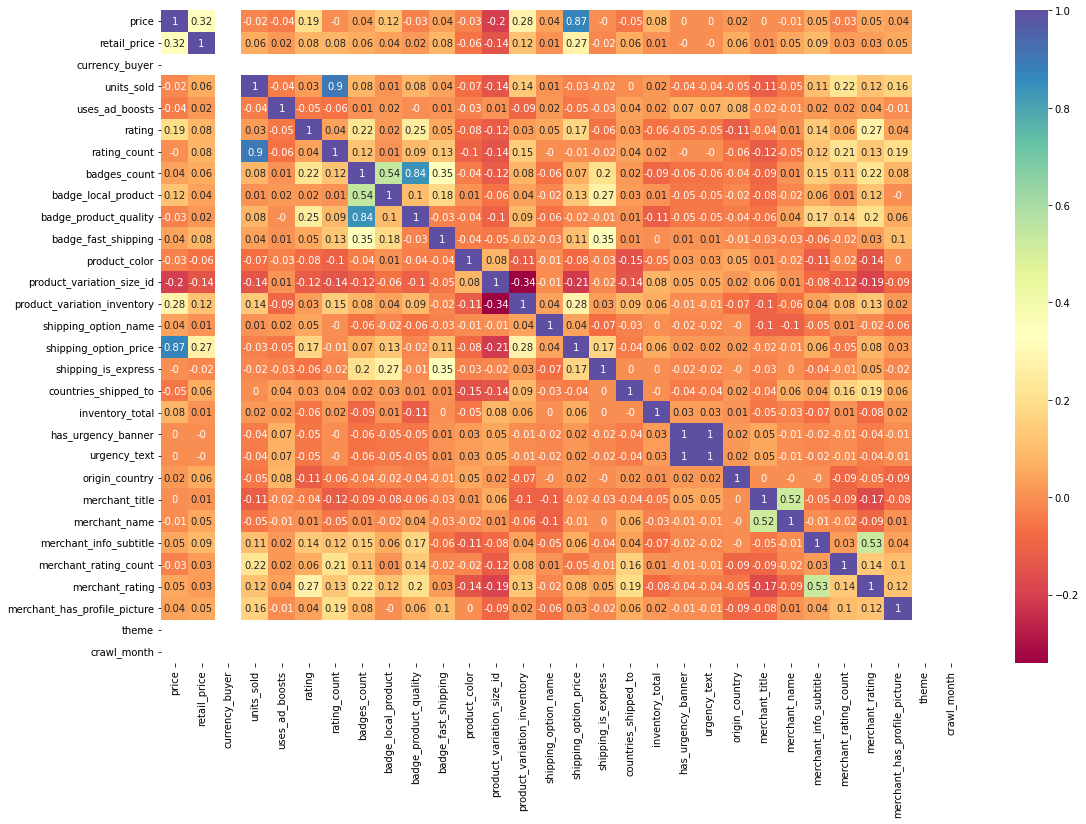

In [22]:
# generate a correlation heatmap using seaborn
plt.figure(figsize=(18,12)) # 18 wide, 12 high
sns.heatmap(data=tr.corr().round(2), cmap='Spectral', annot=True); # spectral is the best cmap, btw 🔥🔥🔥
plt.show()

In [23]:
cols_to_keep = [] # list of columns to persist
abs_corr = tr.corr().abs() # using training split, compute absolute correlation values
for i, rating in enumerate(abs_corr.rating):
  # using a threshold of 0.1, persist all columns with a greater correlation (that aren't the label) 
  if rating > 0.1 and abs_corr.index[i] != 'rating':
    cols_to_keep.append(abs_corr.index[i]) # append column name by keeping track of the index
cols_to_keep # print the columns

['price',
 'badges_count',
 'badge_product_quality',
 'product_variation_size_id',
 'shipping_option_price',
 'origin_country',
 'merchant_info_subtitle',
 'merchant_rating']

In [24]:
# let's use this subset of columns to generate the predictions for this trial
# note that since this is just a subset of columns, the targets remain unchanged
tr_x2 = tr[cols_to_keep]
val_x2 = val[cols_to_keep]
test_2 = test_data[cols_to_keep]

In [25]:
from sklearn import preprocessing

# also, let's adjust our features to one scale (0 mean, 1 variance)
tr_x2 = pd.DataFrame(preprocessing.scale(tr_x2))
val_x2 = pd.DataFrame(preprocessing.scale(val_x2))
test_2 = pd.DataFrame(preprocessing.scale(test_2))

In [26]:
# compute validation score for trial 2 using tweaked logistic regression
# classifier from trial 1
score = train_and_validate(clf2, tr_x2, tr_y, val_x2, val_y)

In [27]:
score # this is a bit better, still lots of room to grow, however 😒

0.718849840255591

In [28]:
# generating predictions for trial 2
test(clf2,'trial2', test_2)

### Trial 3 - Additional Pre-processing and Feature Selection

Thoughts and observations for trial 2: improved feature selection improved performance, on the Kaggle leaderboard at least.

Plan for trial 3: similar preprocessing as before, but try imputing missing/NaN values in original dataset with mean, median, and mode (including those columns that are categorically encoded)

In [29]:
# restart with original dataset as before, just not filling NaNs just yet
data2 = pd.read_csv('/content/train_new.csv').sample(frac=1)
data2 = data2.loc[data2['rating'].isin([1, 2, 3, 4, 5])] #turns out there's one record with a rating of 6.0! Didn't notice that right away
data2 = data2.drop(['merchant_id', 'merchant_profile_picture', 'id', 'tags'], axis=1) # drop unhelpful columns

In [30]:
# only a few columns actually have NaNs, so this might not be as effective
# as I thought, see below, only categorical columns appear to have NaNs
(data2.isna().sum()/len(data2))*100

price                            0.000000
retail_price                     0.000000
currency_buyer                   0.000000
units_sold                       0.000000
uses_ad_boosts                   0.000000
rating                           0.000000
rating_count                     0.000000
badges_count                     0.000000
badge_local_product              0.000000
badge_product_quality            0.000000
badge_fast_shipping              0.000000
product_color                    2.653248
product_variation_size_id        1.097896
product_variation_inventory      0.000000
shipping_option_name             0.000000
shipping_option_price            0.000000
shipping_is_express              0.000000
countries_shipped_to             0.000000
inventory_total                  0.000000
has_urgency_banner              68.069533
urgency_text                    68.069533
origin_country                   1.097896
merchant_title                   0.000000
merchant_name                    0

In [31]:
# quick method to impute missing values using different
# measures of central tendency (only mode is relevant for us)
def impute(col):
  most_common = col.mode()
  col.replace([np.nan], most_common) # replace NaNs with most common value
  col = col.astype('category') # convert to categorical
  col = col.cat.codes # assign numeric code when filling missing data
  return col


In [32]:
# however, let's give imputation a go, anyway

# start by a copy of the data, as the one provided filled all NaNs with 0
for x in data2.columns.to_list():
  if x != 'rating': # don't impute the rating
    data2[x] = impute(data2[x])

In [33]:
# now we have no more NaNs, and they weren't all defaulted to 0 this time
data2.isna().sum()

price                           0
retail_price                    0
currency_buyer                  0
units_sold                      0
uses_ad_boosts                  0
rating                          0
rating_count                    0
badges_count                    0
badge_local_product             0
badge_product_quality           0
badge_fast_shipping             0
product_color                   0
product_variation_size_id       0
product_variation_inventory     0
shipping_option_name            0
shipping_option_price           0
shipping_is_express             0
countries_shipped_to            0
inventory_total                 0
has_urgency_banner              0
urgency_text                    0
origin_country                  0
merchant_title                  0
merchant_name                   0
merchant_info_subtitle          0
merchant_rating_count           0
merchant_rating                 0
merchant_has_profile_picture    0
theme                           0
crawl_month   

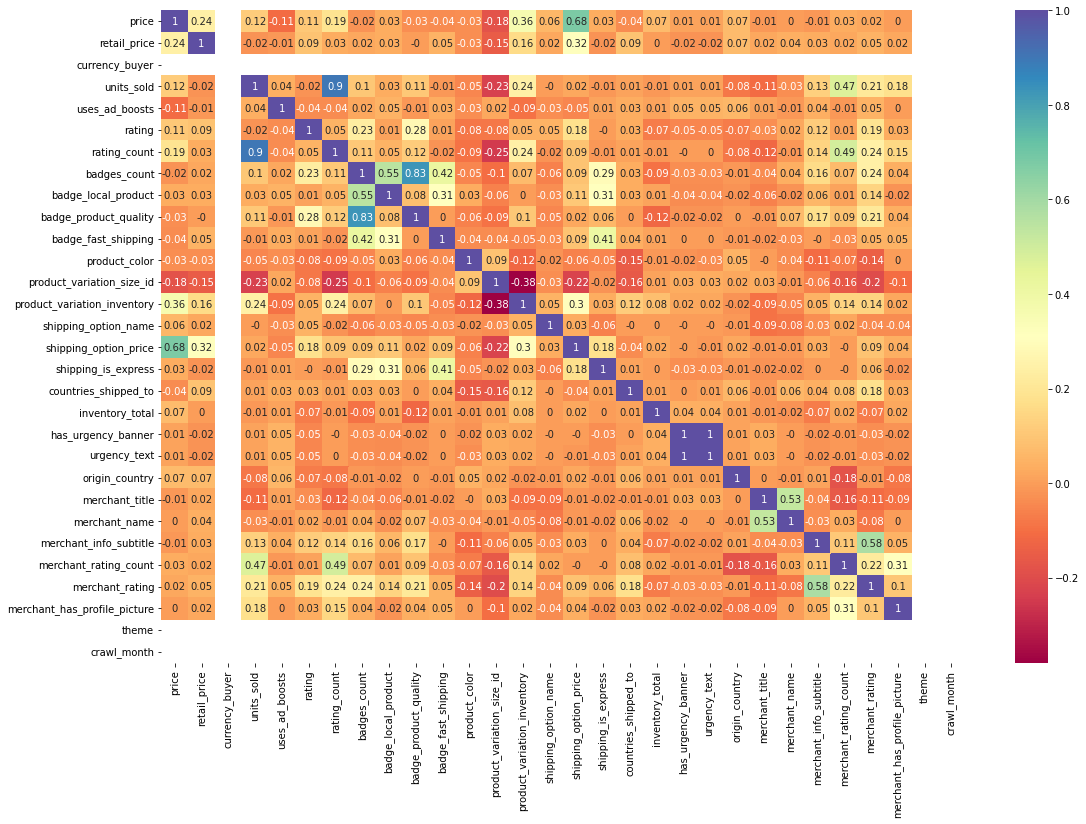

In [127]:
# however, this did not appear to affect the corr values much, if at all (see
# heatmap, generated as done in trial 2)
plt.figure(figsize=(18,12))
sns.heatmap(data=data2.corr().round(2), cmap='Spectral', annot=True);
plt.show()

In [35]:
# get our training and validation splits using the quick function I made
tr_x3, tr_y3, val_x3, val_y3 = split(data2)

In [36]:
# similar to trial 2, I'm going to try using relevant columns, with a slightly different
# threshold to explore any change in performance
cols_to_keep = []
abs_corr = data2.corr().abs()
for i, rating in enumerate(abs_corr.rating):
  if rating > 0.08 and abs_corr.index[i] != 'rating':
    cols_to_keep.append(abs_corr.index[i])
cols_to_keep

['price',
 'retail_price',
 'badges_count',
 'badge_product_quality',
 'product_variation_size_id',
 'shipping_option_price',
 'merchant_info_subtitle',
 'merchant_rating']

In [37]:
# take a slice of all the columns to keep, as before
tr_x3 = tr_x3[cols_to_keep]
val_x3 = val_x3[cols_to_keep]
test_3 = test_data[cols_to_keep]

In [38]:
# convert them all to one scale, as done in trial 2
tr_x3 = pd.DataFrame(preprocessing.scale(tr_x3))
val_x3 = pd.DataFrame(preprocessing.scale(val_x3))
test_3 = pd.DataFrame(preprocessing.scale(test_3))

In [39]:
# still using clf2 from previous trials because I want to improve my preprocessing methodology
score = train_and_validate(clf2, tr_x3, tr_y3, val_x3, val_y3)

In [40]:
score # not much movement yet

0.6813880126182965

In [41]:
# generating predictions for trial 3
test(clf2,'trial3', test_3)

In [42]:
# training f1 and val f1 still aren't very good
train_preds = clf2.predict(tr_x3)
f1_score(tr_y3, train_preds, average='micro')

0.7306701030927835

### Trial 4 - Systematic Feature Selection, Decision Tree

Thoughts and observations for trial 3: Adding imputation for preprocessing instead of zero-padding missing data (NaNs) didn't do much, and expanding the correlation threshold for selecting relevant features didn't improve performance either. My best results are still from trial 2.

Plan for trial 4: another preprocessing step I want to do is use a technique I've used before for feature selection, where I use the feature importances/coefficients to explore where a dropoff occurs, and use all the features up to that point. This ensures that the right amount of noise is removed when training, without omitting any useful detail.

In [43]:
# start by normalizing all numeric features (not categorically encoded columns)
cat_cols = data.columns[data.dtypes==object].to_list()
cols_to_normalize = tr.drop(columns=cat_cols).columns.to_list() # find non-categorical columns to normalize
cols_to_normalize.remove('rating') # remove rating as we don't want to normalize the label
for col in cols_to_normalize: # trying min-max normalization this time (yes, I wrote it by hand even though MinMaxScaler() is available)
  tr[col] = (tr[col] - tr[col].min()) / (tr[col].max() - tr[col].min())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [44]:
# do the same for the validation split
for col in cols_to_normalize: # trying min-max normalization this time
  val[col] = (val[col] - val[col].min()) / (val[col].max() - val[col].min())

In [45]:
# moving the label column to the front so it's easier to visualize the corr values
cols = tr.drop(columns=['rating']).columns.to_list()
cols = ['rating'] + cols # shifting label to the front

#adjusting column order in training and validation splits
tr = tr.reindex(columns=cols)
val = val.reindex(columns=cols)
val.head() # just easier for me to see the label/target at the front, too

,rating,price,retail_price,currency_buyer,units_sold,uses_ad_boosts,rating_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,product_color,product_variation_size_id,product_variation_inventory,shipping_option_name,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,urgency_text,origin_country,merchant_title,merchant_name,merchant_info_subtitle,merchant_rating_count,merchant_rating,merchant_has_profile_picture,theme,crawl_month
301,4.0,0.194,0.164,0,0.00099,1.0,0.003737,0.0,0.0,0.0,0.0,44.0,-1.0,1.000000,4.0,0.000000,0.0,0.282443,1.0,0.0,0.0,1,-1.0,-1.0,-1.0,0.006149,0.846123,1.0,0,0
16,4.0,0.200,0.016,0,0.04999,0.0,0.042023,0.0,0.0,0.0,0.0,72.0,58.0,0.122449,4.0,0.166667,0.0,0.122137,1.0,0.0,0.0,1,-1.0,-1.0,-1.0,0.006634,0.506073,0.0,0,0
756,4.0,0.440,0.332,0,0.00999,1.0,0.012707,0.0,0.0,0.0,0.0,-1.0,34.0,1.000000,4.0,0.333333,0.0,0.244275,1.0,1.0,1.0,1,-1.0,-1.0,-1.0,0.048580,0.776520,0.0,0,0
924,4.0,0.480,0.128,0,0.00099,0.0,0.004485,0.0,0.0,0.0,0.0,72.0,58.0,1.000000,4.0,0.333333,0.0,0.251908,1.0,0.0,0.0,1,269.0,41.0,341.0,0.012736,0.616830,0.0,0,0
704,5.0,0.120,0.008,0,0.00099,1.0,0.000166,0.0,0.0,0.0,0.0,52.0,58.0,0.000000,4.0,0.000000,0.0,0.091603,1.0,0.0,0.0,1,-1.0,-1.0,-1.0,0.008446,0.747569,0.0,0,0


In [46]:
# to start looking at feature importances, start by fitting a simple LogReg
# to resolve feature importances
x = tr.drop(columns=['rating'])
y = tr['rating']

In [47]:
clf2.fit(x,y) # fit using the same basic classifier from trial 2

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

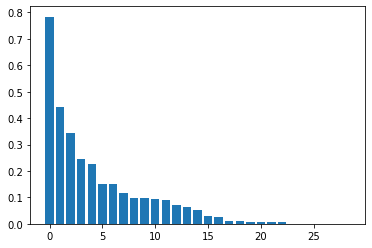

In [48]:
importance = np.abs(clf2.coef_[0]) # store all coefficients in a list
sorted = -np.sort(-importance) # sort in descending order

# plot them to observe where dropoff occurs
plt.bar([x for x in range(len(sorted))], sorted) 
plt.show()

In [49]:
# It looks like the dropoff occurs after the 11th bar, so I'll use the first 11 features
cols_to_drop = [] # keep track of columns to drop using thresholding
thresh = sorted[11] # coefficient value where visible dropoff occurs
print(thresh)
for n, imp in enumerate(importance):
  if imp < thresh:
    print(imp) # used to verify that we're dropping features we should
    cols_to_drop.append(tr.columns[n+1]) # shift over index by 1 because the dataframe starts with the rating label

# drop the columns from the training and validation splits
tr4 = tr.drop(columns=cols_to_drop,axis=1)
val4 = val.drop(columns=cols_to_drop,axis=1)

0.09161540473876978
0.0
0.029040970907436143
0.02595258284205664
0.05303045441805695
0.0005013823962938865
0.0073827063202488484
0.06372768212874207
1.6477860558927224e-05
6.530532790192252e-05
0.010595334318749657
0.01037100100749335
0.005720742258127342
0.00664620183200745
0.005397821932276276
0.07092970947235851
0.0
0.0


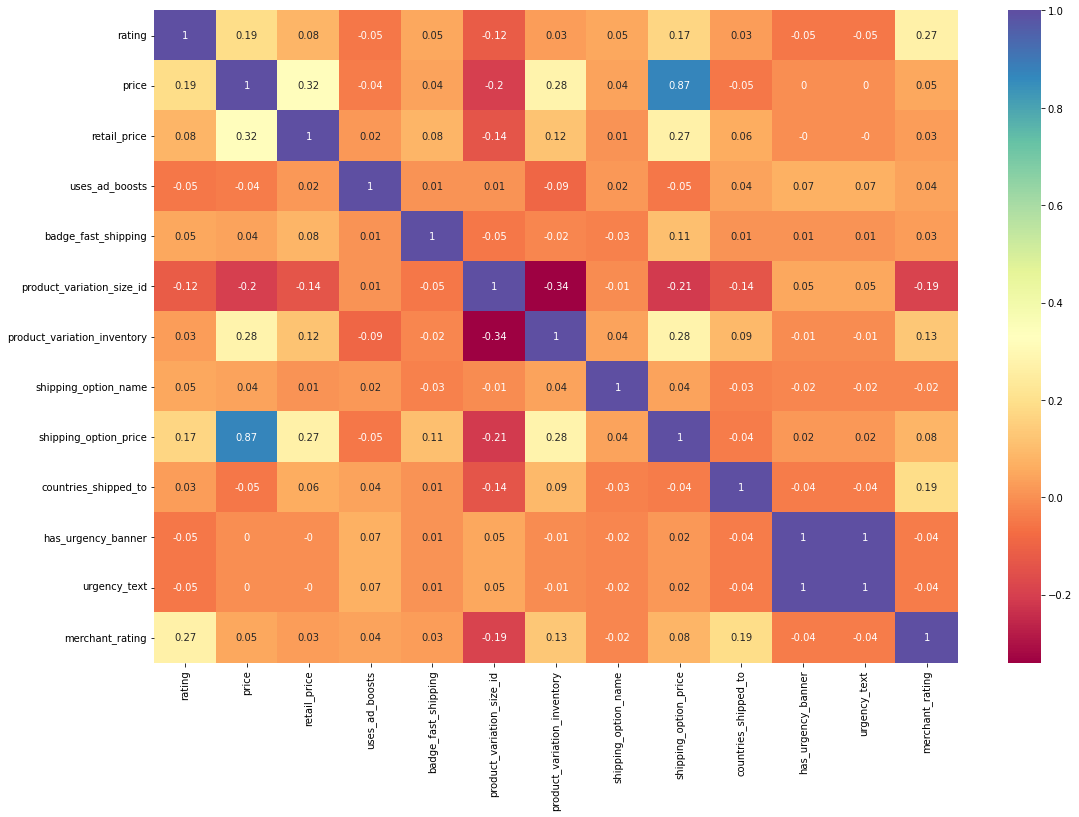

In [50]:
# another heatmap, with a better selection of columns this time
plt.figure(figsize=(18,12))
sns.heatmap(data=tr4.corr().round(2), cmap='Spectral', annot=True);
plt.show()

In [51]:
# remove one of the two columns that have a 1:1 correlation
tr4.drop(columns=['urgency_text'], inplace=True)
val4.drop(columns=['urgency_text'], inplace=True)

In [52]:
# splitting our features and labels, once again
tr_x4 = tr4.drop(columns=['rating'])
tr_y4 = tr4['rating']
val_x4 = val4.drop(columns=['rating'])
val_y4 = val4['rating']

In [53]:
# prep test data, same as training and validation
test_4 = test_data.copy()
for col in cols_to_normalize: # min-max normalization, once again
  test_4[col] = (test_4[col] - test_4[col].min()) / (test_4[col].max() - test_4[col].min())
cols_to_drop.append('urgency_text')
test_4.drop(columns=cols_to_drop, axis=1, inplace=True)

In [54]:
# this didn't improve the validation score much
score = train_and_validate(clf2, tr_x4, tr_y4, val_x4, val_y4)
score

0.6613418530351438

In [55]:
# This isn't improving my score at all?! I guess it just introduced more noise?
# Now I'm going to hand-pick features from the correlation heatmap
# to see if I can beat my score from trial 2

tr_x4.drop(columns=['product_variation_size_id',
                    'product_variation_inventory',
                    'shipping_option_name',
                    'uses_ad_boosts'])

val_x4.drop(columns=['product_variation_size_id',
                    'product_variation_inventory',
                    'shipping_option_name',
                    'uses_ad_boosts'])

test_4.drop(columns=['product_variation_size_id',
                    'product_variation_inventory',
                    'shipping_option_name',
                    'uses_ad_boosts'])

,price,retail_price,badge_fast_shipping,shipping_option_price,countries_shipped_to,has_urgency_banner,merchant_rating
295,0.204211,0.143713,0.0,0.000000,0.261194,0.0,0.605047
308,0.263158,0.071856,0.0,0.166667,0.276119,0.0,0.693096
411,0.210526,0.023952,0.0,0.166667,0.014925,0.0,0.563953
17,0.245263,0.023952,0.0,0.166667,0.268657,1.0,0.732099
379,0.315789,0.329341,0.0,0.166667,0.261194,0.0,0.625580
...,...,...,...,...,...,...,...
118,0.087895,0.395210,0.0,0.000000,0.156716,1.0,0.509615
407,0.034211,0.005988,0.0,0.000000,0.238806,1.0,0.609546
284,0.526316,0.053892,0.0,0.166667,0.134328,0.0,0.556594
363,0.090000,0.011976,0.0,0.000000,0.231343,0.0,0.667969


In [56]:
# again, no improvement 😡
score = train_and_validate(clf2, tr_x4, tr_y4, val_x4, val_y4)
score

0.6613418530351438

In [57]:
# Still not getting anywhere. I'm going to try a different classifier and see
# if I've hit a ceiling here, and then I'll add cross-validation in the next
# trial
from sklearn.tree import DecisionTreeClassifier
clf3 = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', splitter='random')
# score = train_and_validate(clf3, tr_x2, tr_y, val_x2, val_y)
# score

In [58]:
# even worse
score = train_and_validate(clf3, tr_x4, tr_y4, val_x4, val_y4)
score

0.597444089456869

In [59]:
# training f1 is high, so the decision tree is overfitting
train_preds = clf3.predict(tr_x4)
f1_score(tr_y4, train_preds, average='micro')

0.9987179487179487

In [60]:
# I was curious about overfitting, so I follow the tutorial here:
# https://ranvir.xyz/blog/practical-approach-to-tree-pruning-using-sklearn/
# to learn how to reduce overfitting using cost complexity pruning, see below
path = clf3.cost_complexity_pruning_path(tr_x4, tr_y4) # dict containing ccp_alphas and impurities

Text(0, 0.5, 'total impurity of leaves')

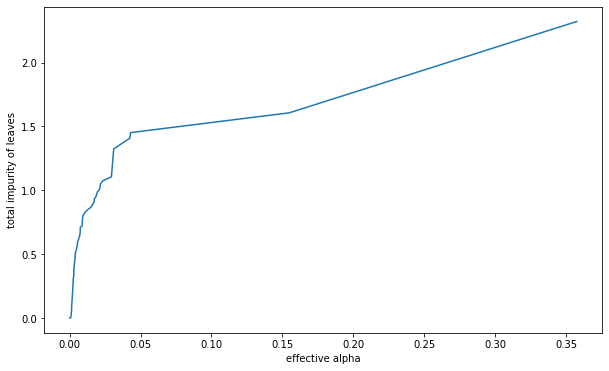

In [61]:
# plotting relationship between impurities and alpha values
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")

In [62]:
# now, let's find an optimal alpha value, programatically
clfrs = []

# generate a classifier for each alpha value and append it to a list
for ccp_alpha in ccp_alphas:
    clfr = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clfr.fit(tr_x4, tr_y4)
    clfrs.append(clfr)

Text(0, 0.5, 'total depth')

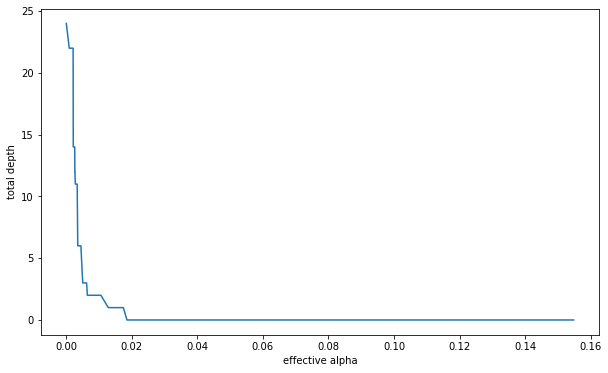

In [63]:
# exploring the relationship between alpha and tree depth
tree_depths = [clfr.tree_.max_depth for clfr in clfrs]
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")

Text(0, 0.5, 'Accuracy scores')

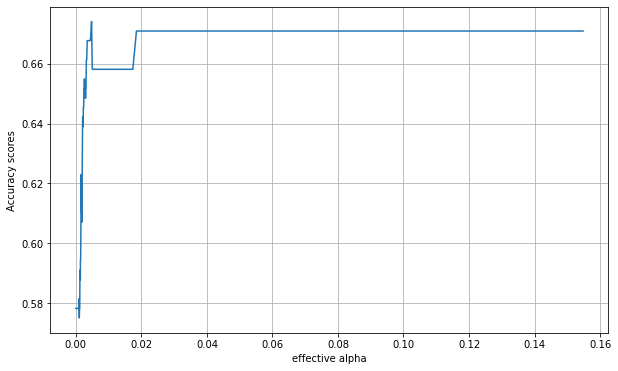

In [64]:
# exploring how accuracy varies with alpha (plateaus at ~0.02)
from sklearn.metrics import accuracy_score

acc_scores = [accuracy_score(val_y4, clfr.predict(val_x4)) for clfr in clfrs]

tree_depths = [clfr.tree_.max_depth for clfr in clfrs]
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Accuracy scores")

In [65]:
# end of tutorial, looks like the best ccp_alpha value is ~0.020
clf3 = DecisionTreeClassifier(ccp_alpha=0.020, criterion='entropy', splitter='random')

In [66]:
# not much improvement in the validation score
score = train_and_validate(clf3, tr_x4, tr_y4, val_x4, val_y4)
score

0.6677316293929713

In [67]:
# training f1-score exhibits less overfitting, but the score hasn't improved much
train_preds = clf3.predict(tr_x4)
f1_score(tr_y4, train_preds, average='micro')

0.7307692307692306

In [68]:
# don't even want to bother testing this one since there's a daily cap, 
# but this cell will generate a csv anyway 🐕‍🦺💩
test(clf3,'trial4', test_4)

### Trial 5 - Introducing k-Fold Cross-Validation

Thoughts and observations for trial 4: A more systematic approach to feature selection didn't result in higher performance, even using a hand-picked selection from the correlation heatmap. I tried using a different model (DecisionTree) and varied the hyperparameters to maximize the f1-score on the validation set, but the score was significantly worse ~0.63. I also want to note that low correlation values may not necessarily indicate no relevance, as the dataset is very small. It also overfit to the training set (>0.99 training f1). Using the DS life cycle for tuning, we have a high variance situation, so we need more data, regularization, or a different model architecture.

Plan for trial 5: One last preprocessing technique I want to do is k-fold cross validation instead of using the same 70/30 split as before. The dataset is small (train_new.csv has just 1093 samples, test_new.csv has just 479 samples), and the dataset is heavily imbalanced in favour of records with a product rating 4. Our train/validation/test split is currently Let's try k-fold to see if we get a model that generalizes better 😊

In [69]:
# current splits
print(f"Training split: {round(tr4.shape[0]/(len(data2)+len(test_data))*100,2)}%")
print(f"Validation split: {round(val4.shape[0]/(len(data2)+len(test_data))*100,2)}%")
print(f"Testing split: {round(test_4.shape[0]/(len(data2)+len(test_data))*100,2)}%")

Training split: 49.62%
Validation split: 19.91%
Testing split: 30.47%


In [70]:
# starting over and using similar preprocessing as in trial 2
from sklearn.model_selection import cross_validate
for col in cols_to_normalize: # get all numerical columns down to one scale
  data2[col] = preprocessing.scale(data2[col])

In [71]:
# apply the same preprocessing measure to the test set
test_5 = test_data.copy()
for col in cols_to_normalize: # get all numerical columns down to one scale
  test_5[col] = preprocessing.scale(test_5[col])
test_5 = test_5[cols_to_keep]

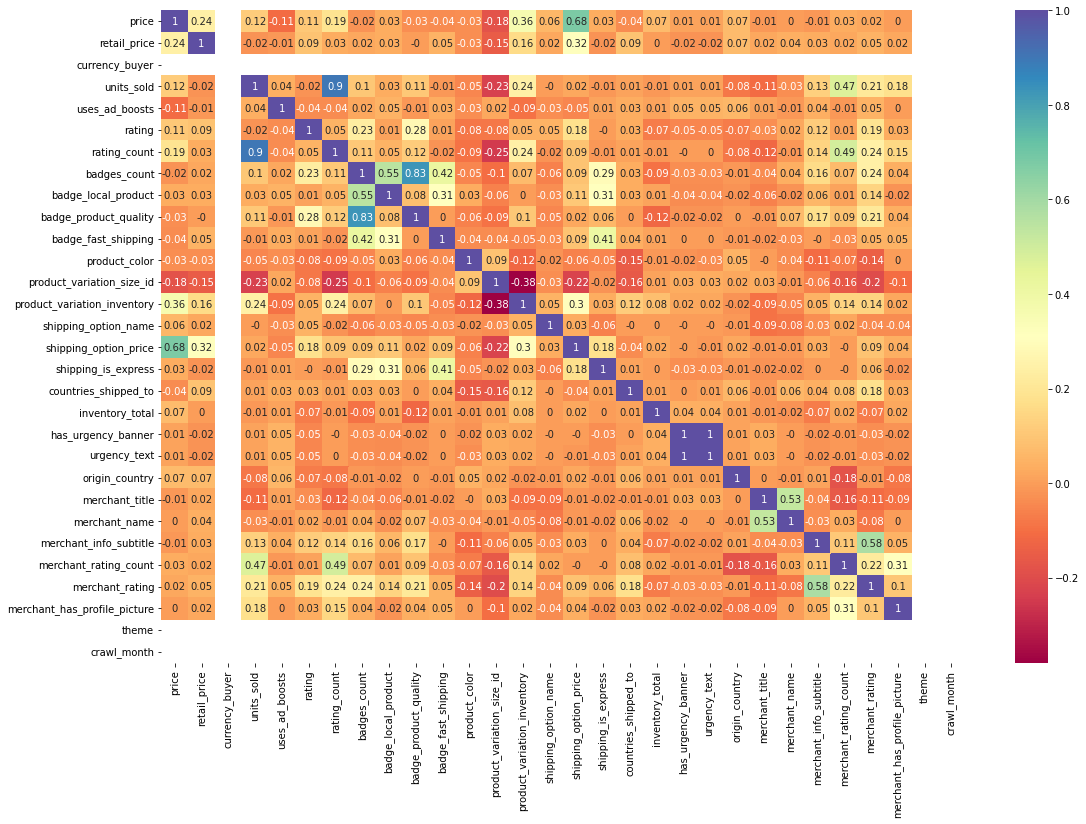

In [72]:
# generating another heatmap to show things are similar to before
plt.figure(figsize=(18,12))
sns.heatmap(data=data2.corr().round(2), cmap='Spectral', annot=True);
plt.show()

In [73]:
# creating slices for features and labels prior to cross validation
tr_x5 = data2[cols_to_keep]
tr_y5 = data2['rating']

In [74]:
# instantiate decision tree classifier, manually tweaked hyperparameters
clf3 = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', splitter='random', max_depth=100)

In [75]:
scores = cross_validate(clf3, tr_x5, tr_y5, scoring='f1_micro', cv=10, return_estimator=True)
estimators = scores['estimator']
best_score_ind = np.argmax(scores['test_score'])
best_score = max(scores['test_score'])
clf4 = estimators[best_score_ind]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [76]:
print(f'using 10-fold cross-validation, the best observed f1-score was: {best_score}')

using 10-fold cross-validation, the best observed f1-score was: 0.7363636363636363


In [77]:
# using this estimator, the training f1 still shows overfitting
train_preds = clf4.predict(tr_x5)
f1_score(tr_y5, train_preds, average='micro')

0.9634034766697164

In [78]:
# using the best estimator from 10-fold cross validation to generate predictions
# for this trial
test(clf4,'trial5', test_5)

### Trial 6 - Support Vector Machine and Oversampling

Thoughts and observations for trial 5: cross-validation allows for a model to be exposed to more training samples and for the best estimator to be used for testing. Among the estimators using the decision tree classifier, some of the validation scores entered the high 70s. This is great news, as pairing cross validation with oversampling and ensemble methods should allow it to generalize better when testing. (Haven't tested on Kaggle yet because I have one more daily submission and want to wait for my best results)

Plan for trial 6: Since cross-validation had a positive result on the development folds, I want to oversample the minority classes and explore performance

In [79]:
# I had to remove the two records with a rating of 1 as I had a hard time getting
# oversampling to work, hope this isn't an issue (I felt they were outliers anyway)
data3 = data.copy()
data3 = data3.loc[data3.rating > 1] 
test_6 = test_data.copy()

In [80]:
# preprocessing, as before (normalizing to one scale)
for col in cols_to_normalize:
  data3[col] = preprocessing.scale(data3[col])
  test_6[col] = preprocessing.scale(test_6[col])

In [ ]:
# heatmap for all training data, just to show that nothing has changed
plt.figure(figsize=(18,12))
sns.heatmap(data=data3.corr().round(2), cmap='Spectral', annot=True);
plt.show()

In [82]:
# I'm going to go back to using a correlation threshold because that
# gave me my highest score so far (trial 2)
cols_to_keep = []
abs_corr = data3.corr().abs()
for i, rating in enumerate(abs_corr.rating):
  if rating > 0.08:
    cols_to_keep.append(abs_corr.index[i])
cols_to_keep

['price',
 'retail_price',
 'rating',
 'badges_count',
 'badge_product_quality',
 'shipping_option_price',
 'merchant_rating']

In [83]:
# use columns from thresholding to slice train and test sets
data3 = data3[cols_to_keep]
cols_to_keep.remove('rating') # rating doesn't exist in test set, so remove before dropping
test_6 = test_6[cols_to_keep]

In [84]:
# create slices of labels and features
tr_x6 = data3.drop(columns=['rating'])
tr_y6 = data3['rating']

In [85]:
# test another model type, SVM
from sklearn import svm
from sklearn.model_selection import cross_val_score
clf5 = svm.SVC(kernel='poly') # non-linear kernel for added complexity

### THIS IS WHERE I MADE MISTAKES
Disclaimer: To account for the imbalanced dataset, I tried to use Synthetic Minority Class Oversampling Technique (SMOTE)

I couldn't submit to the kaggle leaderboard because I was capped out, so I thought my validation score was a good sign after oversampling, so I kept going with the methodology I had planned to do (cross validation, oversampling, ensemble methods). Scores kept getting better, which I thought was a good sign from following the DS tuning life cycle. I was very wrong (test f1-score on public leaderboard 0.51)

In [86]:
# to handle imbalanced data, I used the following resource to learn how SMOTE works:
# https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
from imblearn.over_sampling import SMOTE

os = SMOTE() # instantiate SMOTE object
tr_x6, tr_y6 = os.fit_resample(tr_x6, tr_y6) # fit the distribution to the training data

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [109]:
# The support vector classifier results are not good
scores = cross_validate(clf5, tr_x6, tr_y6, scoring='f1_micro', cv=10, return_estimator=True)
estimators = scores['estimator']
best_score_ind = np.argmax(scores['test_score'])
best_score = max(scores['test_score'])
clf6 = estimators[best_score_ind]

In [110]:
print(f'using 10-fold cross-validation, the best observed f1-score was: {best_score}')

using 10-fold cross-validation, the best observed f1-score was: 0.5825242718446602


In [111]:
# THIS IS A LOGICAL ERROR I MADE
# WOW! These numbers are much better. I tried all the classifiers I've
# implemented so far, and this is the best yet--the optimized decision tree
# from trial 5 (clf4)
scores = cross_validate(clf4, tr_x6, tr_y6, scoring='f1_micro', cv=10, return_estimator=True)
estimators = scores['estimator']
best_score_ind = np.argmax(scores['test_score'])
best_score = max(scores['test_score'])
clf6 = estimators[best_score_ind]

In [112]:
print(f'using 10-fold cross-validation, the best observed f1-score was: {best_score}')

using 10-fold cross-validation, the best observed f1-score was: 0.8322580645161292


In [113]:
# checking the performance of this estimator on the whole training set
train_preds = clf6.predict(tr_x6)
f1_score(tr_y6, train_preds, average='micro')

# looks like it's overfitting, but the validation scores are encouraging
# Note that I tried to reduce overfitting using cost complexity pruning in a
# previous trial

0.9790051679586563

In [90]:
# using the best estimator from 10-fold cross validation to generate predictions
# for trial 6
test(clf6,'trial6', test_6)

### Trial 7 - Ensemble Methods, Starting with Random Forest

Thoughts and observations for trial 6: Apparent overfitting aside, the best cross-validation score after over-sampling is very encouraging. Interesting however, that the decision tree performed so well (mid 70s, mid 80s), yet the logistic regression and svm classifiers performed much worse (mid 50s).

Plan for trial 7: In reference to the DS life cycle for tuning, both train and dev scores are high, so the last thing to do is improve the score on the testing data (Kaggle). I'm out of daily submissions so I'll wait until 8PM EST to submit more. I'll see how high I can get my validation f1-score and make my last submission for the day.

Cross-validation and oversampling have improved performance. So, the last thing I want to explore is the performance of ensemble methods. The decision tree appears to perform well, but what if we had...several trees? 😎 🌳🌳🌳🌳🌳

Let's give random forest a try.

In [91]:
# Initializing random forest instance
from sklearn.ensemble import RandomForestClassifier
clf7 = RandomForestClassifier() # starting with no hyperparameters

In [92]:
# as before, compute validation scores and extract the best estimator
scores = cross_validate(clf7, tr_x6, tr_y6, scoring='f1_micro', cv=10, return_estimator=True)
estimators = scores['estimator']
best_score_ind = np.argmax(scores['test_score'])
best_score = max(scores['test_score'])
clf7 = estimators[best_score_ind]
print(f'using 10-fold cross-validation, the best observed f1-score was: {best_score}')

using 10-fold cross-validation, the best observed f1-score was: 0.9096774193548387


In [93]:
# once again, checking training f1-score on the whole training set
# with a new high validation score from the best estimator above
train_preds = clf7.predict(tr_x6)
f1_score(tr_y6, train_preds, average='micro')

0.9864341085271318

In [94]:
tr_x6 # SMOTE changed the training set to an array, still works though

array([[-0.63681069,  0.60562899, -0.32687085, -0.30166206, -1.33504635,
         1.52464722],
       [ 0.70649529, -0.43159204, -0.32687085, -0.30166206,  0.66020785,
        -2.40973023],
       [-0.07601305, -0.52588486, -0.32687085, -0.30166206, -0.33741925,
         0.08757094],
       ...,
       [ 2.10443759, -0.29456992,  6.23333495,  3.31496772,  3.29447605,
         1.26847049],
       [-0.67969303, -0.40400608,  2.54906546,  3.31496772, -0.59352949,
        -0.37465933],
       [ 1.48900363,  2.07961371, -0.32687085, -0.30166206,  0.66020785,
         0.9276616 ]])

In [95]:
# generating trial 7 predictions
test(clf7,'trial7', test_6)

### Trial 8 - Base XGBoost Classifier (Ensemble Methods ctd.)

Thoughts and observations for trial 7: Using the same preprocessed dataset as in trial 6, random forest exhibited an improvement over the optimized decision tree classifier (with no hyperparameter tuning...yet)

Plan for trial 8: I want to try XGBoost (extreme gradient boosting) as it is known to be a powerful implementation of the gradient boosting ensemble algorithm. I believe that this will be the most powerful model I can implement for this task, and the most recent preprocessing measures are proving to be effective. Following the DS life cycle for tuning, the last thing to do is maximize test set performance, and that is my current focus 💣.

In [96]:
# Let's work with XGBoost!
from xgboost import XGBClassifier

# create a default classifier
clf8 = XGBClassifier()

In [97]:
# generating scores and selecting the best estimator
scores = cross_validate(clf8, tr_x6, tr_y6, scoring='f1_micro', cv=10, return_estimator=True)
estimators = scores['estimator']
best_score_ind = np.argmax(scores['test_score'])
best_score = max(scores['test_score'])
clf8 = estimators[best_score_ind]
print(f'using 10-fold cross-validation, the best observed f1-score was: {best_score}')

using 10-fold cross-validation, the best observed f1-score was: 0.7702265372168284


In [98]:
# Surprising that the validation score for the best XGBoost estimator is 
# significantly lower than the base RandomForestClassifier

# Checking training f1, which isn't in the high 0.9s like many others,
# so there's room to grow here.
train_preds = clf8.predict(tr_x6)
f1_score(tr_y6, train_preds, average='micro')

0.7697028423772608

In [99]:
# generating predictions on test set for trial 8
# need to use test_6.values to pass dataframe contents as an array
test(clf8, 'trial8', test_6.values)

### Trial 9 - Tuning Hyperparameters

**If I didn't make a mistake using SMOTE, I still would have done the same approach for training and tuning hyperparameters**

Thoughts and observations for trial 8: A baseline XGBoost classifier did not perform as well as the RandomForest classifier, but it also did not overfit to the training data...yet. So, there's room to grow and improve the validation score.

Plan for trial 9: The two ensemble algorithms I have applied (RandomForest and XGBoost) have yielded the best results so far, along with the decision tree classifier. So, in this trial I will optimize hyperparameters with the objective of maximizing validation set accuracy before submitting.

In [105]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [5, 10, 15, 20],
    "n_estimators": [100, 250, 500],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}

# tuning XGBoost
grid = RandomizedSearchCV(estimator=clf8, param_distributions=param_grid, scoring='f1_micro', cv=10, n_iter=50)
%time optimized_xgboost = grid.fit(tr_x6, tr_y6)

CPU times: user 29min 8s, sys: 21.9 s, total: 29min 30s
Wall time: 29min 21s


In [107]:
optimized_xgboost.best_score_ # best score from RandomSearch

0.8582409437310785

In [108]:
optimized_xgboost.best_params_ # best parameter configuration from RandomSearch

{'colsample_bytree': 1.0,
 'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 20,
 'n_estimators': 250,
 'reg_lambda': 2,
 'subsample': 0.6}

In [136]:
# this will generate a csv for trial 9, but the results won't be very good
test(optimized_xgboost, 'trial9', test_6.values)

### Trial 10+ - Continued Experimentation/Appendix, Optimizing Random Forest and XGBoost

Thoughts and observations for trial 9: It was after trial 9 that I discovered the issue with SMOTE, where training and validation f1-scores were high, but the testing score on kaggle was low (0.51). Since trials 6-9 are based on this methodology, those test results will score poorly, too.

Plan for trial 10 (and onward): Starting with my best preprocessing results so far (from trial 5, before I messed everything up with SMOTE in trials 6-9), the steps I will follow in this trial are as follows:

*   Feature Selection
*   Cross Validation and Model Selection (Ensemble Algorithms)
*   Hyperparameter Tuning



In [128]:
# preprocessing, as before (normalizing to one scale)
data4 = data2.copy()
test_7 = test_data.copy()
for col in cols_to_normalize:
  data4[col] = preprocessing.scale(data4[col])
  test_7[col] = preprocessing.scale(test_7[col])

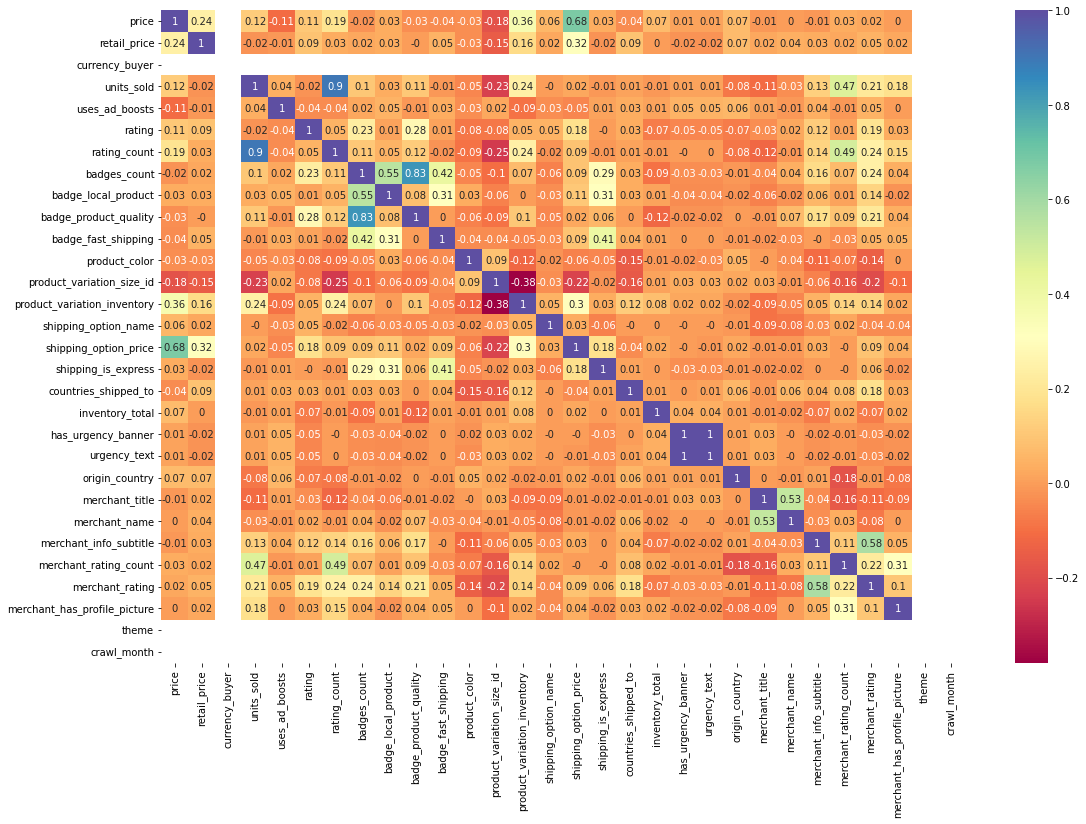

In [129]:
# generating another heatmap to show things are similar to before
plt.figure(figsize=(18,12))
sns.heatmap(data=data4.corr().round(2), cmap='Spectral', annot=True);
plt.show()

In [130]:
cols_to_keep = [] # list of columns to persist
abs_corr = tr.corr().abs() # using training split, compute absolute correlation values
for i, rating in enumerate(abs_corr.rating):
  # using a threshold of 0.1, persist all columns with a greater correlation (that aren't the label) 
  if rating > 0.08 and abs_corr.index[i] != 'rating':
    cols_to_keep.append(abs_corr.index[i]) # append column name by keeping track of the index
cols_to_keep # print the columns

['price',
 'retail_price',
 'badges_count',
 'badge_product_quality',
 'product_color',
 'product_variation_size_id',
 'shipping_option_price',
 'origin_country',
 'merchant_info_subtitle',
 'merchant_rating']

In [131]:
# creating slices for features and labels prior to cross validation
tr_x7 = data4[cols_to_keep]
tr_y7 = data4['rating']

In [151]:
# taking the same slice of features from the test set
test_7 = test_7[cols_to_keep]

In [120]:
# instantiating random forest classifier
rf_clf = RandomForestClassifier()

In [133]:
# using cross validation, select best estimator as before
scores = cross_validate(rf_clf, tr_x7, tr_y7, scoring='f1_micro', cv=10, return_estimator=True)
estimators = scores['estimator']
best_score_ind = np.argmax(scores['test_score'])
best_score = max(scores['test_score'])
rf_clf = estimators[best_score_ind]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [134]:
print(f'using 10-fold cross-validation, the best observed f1-score was: {best_score}')

using 10-fold cross-validation, the best observed f1-score was: 0.7981651376146789


In [135]:
# training f1 still shows overfitting
train_preds = rf_clf.predict(tr_x7)
f1_score(tr_y7, train_preds, average='micro')

0.970722781335773

In [137]:
# Now I'm going to train and select an XGBoost classifier before hyperparameter tuning
xgb = XGBClassifier()
scores = cross_validate(xgb, tr_x7, tr_y7, scoring='f1_micro', cv=10, return_estimator=True)
estimators = scores['estimator']
best_score_ind = np.argmax(scores['test_score'])
best_score = max(scores['test_score'])
xgb = estimators[best_score_ind]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [138]:
print(f'using 10-fold cross-validation, the best observed f1-score was: {best_score}')

using 10-fold cross-validation, the best observed f1-score was: 0.779816513761468


In [142]:
# hyperparameter tuning: RandomForest
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "n_estimators": [100, 250, 500],
    "max_depth": [5, 10, 15, 20],
    "criterion": ['gini', 'entropy'],
    "max_features": ['auto', 'sqrt', 'log2'],
    "bootstrap": [True, False]
}

# tuning RF model
grid = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_grid, scoring='f1_micro', cv=8, n_iter=50)
%time optimized_random_forest = grid.fit(tr_x7, tr_y7)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)


CPU times: user 5min 35s, sys: 1.7 s, total: 5min 37s
Wall time: 5min 36s


In [143]:
optimized_random_forest.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [144]:
optimized_random_forest.best_score_

0.7785664448261057

In [155]:
# one last time, checking training performance for the RF classifier
train_preds = optimized_random_forest.predict(tr_x7)
f1_score(tr_y7, train_preds, average='micro')

# looks like it remains overfitting to training data

0.989935956084172

In [153]:
test(optimized_random_forest, 'trial10_rf', test_7)

In [146]:
# hyperparameter tuning: XGBoost
param_grid = {
    "learning_rate": [0.1, 0.2],
    "colsample_bytree": [0.8, 1.0, 1.2],
    "subsample": [0.5, 0.6],
    "max_depth": [10, 15, 20],
    "n_estimators": [250, 500],
    "reg_lambda": [2, 3, 4],
    "gamma": [0.3, 0.5],
}

# tuning XGBoost
grid = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, scoring='f1_micro', cv=8, n_iter=50)
%time optimized_xgboost = grid.fit(tr_x7, tr_y7)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: value 1.2 for Parameter colsample_bytree exceed bound [0,1]

  FitFailedWarning)


CPU times: user 6min 41s, sys: 7.32 s, total: 6min 49s
Wall time: 6min 47s


In [147]:
optimized_xgboost.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.3,
 'learning_rate': 0.2,
 'max_depth': 20,
 'n_estimators': 500,
 'reg_lambda': 3,
 'subsample': 0.5}

In [148]:
optimized_xgboost.best_score_

0.7511539287247746

In [156]:
# one last time, checking training performance for the RF classifier
train_preds = optimized_xgboost.predict(tr_x7)
f1_score(tr_y7, train_preds, average='micro')

# looks like it remains overfitting to training data as well

0.9908508691674291

In [154]:
test(optimized_xgboost, 'trial10_xg', test_7)

## Task 5 - Questions

**Q1. Why Data Mining is a misnomer? What is another preferred name?**

A1. The process of Data Mining involves acquiring useful, non-trivial knowledge from huge amounts of data ("big data"). However, mining implies the extraction of all data in its raw form without any reason. Other preferred names are knowledge discovery in databases (KDD), business intelligence, and data analysis

**Q2. What is the general knowledge discovery process? What is the difference between a data engineer and data scientist/AI engineer?**

A2. The general knowledge discovery process details the steps used to analyze data and to extract knowledge. In order, this requires raw data acquisition, data pre-processing (cleaning), data warehousing, identifying task-relevant data, then analyzing any patterns required to synthesize knowledge from the data. The differences between a data engineer and a data scientist/AI engineer are as follows. A data engineer is involved with creating efficient workflows/pipelines to automate the ingestion of required datasets. Data scientists follows the standard KDD process for collecting, cleaning, and transforming data for machine learning and deep learning applications. 

**Q3. In data mining, what is the difference between prediction and categorization?**

A3. The word "prediction" is used in data mining applications when the target attribute is numeric (i.e. predicting the price of a house), whereas categorization is used when the target attribute or label is categorical (i.e. classifying whether a picture contains a cow or a moose).


**Q4. In a linear model, which regularization method encourages sparsity?**

A4. The L-1 regularization method, also called the Lasso regularizer. The square region created by L1 regularization reduces the weights of uninformative features at each iteration, eventually to zero while other features remain large. L2 regularization has a circular region that removes a small percentage of weights each iteration, but never reaching zero. So, L1 encourages sparsity.

**Q5. Why we need GD for optimization, rather than simply use linear algebra to solve a simple linear model?**

A5. Linear algebra solutions have polynomial complexity and are not scalable for large datasets. They also require all data to be stored in memory at once. So, GD is a cheaper optimization algorithm that gradually reduces empirical error with each iteration until error converges beneath a set threshold, instead of directly computing the most accurate error directly from the dataset using a linear model with matrix operations.

**Q6. In terms of bias and variance, defines what is overfitting and under fitting?**

A6. In the case of overfitting, the model is matching the training data too precisely to generalize to test data points, and has low bias and high variance. Underfitting occurs when the model fails to learn the pattern in the training data w.r.t. the label of interest, and has high bias and low variance. This is further explained by the bias-variance tradeoff in the course material, where training error and test error vary with model complexity.

**Q7. Why data science/machine learning is a bad idea in the context of information security?**


A7. Machine learning applications require large volumes of data, which often involves personal data without explicit consent of customers or people (such as clicking online ads, or watching YouTube videos). This personal information could be exposed in the event of a data breach and render some people vulnerable. Even without a data breach, AI models may include all fields they have access to, even if it isn't pertinent to the ML task in question. This could include additional patterns into a model which could reveal sensitive information to a keen observer. 